# New York City Amenities

I created the following notebook to complete a project for the University of Michigan Coursera course "Applied Plotting, Charting & Data Representation in Python" The assignment was to pick a region and domain category to research and generate visualizations for. 

I would like to know if there is a relationship between some of the key metrics of a neighborhood in New York City like median income, population, and total income, and the number of amenities present in that neighborhood like the number of libraries, farmers markets, flu vaccination sites and licensed businesses? I will be looking specifically at zip code data, as the key metrics of zip codes increase would we expect to see higher numbers of these auxiliary amenities in neighborhoods as well? Or are they independent?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

# Importing and Cleaning Data:

In [4]:
# Start by reading in census income data
census = pd.read_csv('NYC_data/New York City_CensusZipCodeTabulationArea.csv')
census

,placeDcid,placeName,Date:Count_Person,Value:Count_Person,Source:Count_Person,Date:Median_Income_Person,Value:Median_Income_Person,Source:Median_Income_Person
0,zip/10001,10001,2022,27004,https://www.census.gov/programs-surveys/acs/da...,2022.0,72740.0,https://www.census.gov/programs-surveys/acs/da...
1,zip/10002,10002,2022,76518,https://www.census.gov/programs-surveys/acs/da...,2022.0,27471.0,https://www.census.gov/programs-surveys/acs/da...
2,zip/10003,10003,2022,53877,https://www.census.gov/programs-surveys/acs/da...,2022.0,78110.0,https://www.census.gov/programs-surveys/acs/da...
3,zip/10004,10004,2022,4579,https://www.census.gov/programs-surveys/acs/da...,2022.0,130897.0,https://www.census.gov/programs-surveys/acs/da...
4,zip/10005,10005,2022,8801,https://www.census.gov/programs-surveys/acs/da...,2022.0,115806.0,https://www.census.gov/programs-surveys/acs/da...
...,...,...,...,...,...,...,...,...
206,zip/11691,11691,2022,70365,https://www.census.gov/programs-surveys/acs/da...,2022.0,29326.0,https://www.census.gov/programs-surveys/acs/da...
207,zip/11692,11692,2022,24584,https://www.census.gov/programs-surveys/acs/da...,2022.0,31625.0,https://www.census.gov/programs-surveys/acs/da...
208,zip/11693,11693,2022,13558,https://www.census.gov/programs-surveys/acs/da...,2022.0,39613.0,https://www.census.gov/programs-surveys/acs/da...
209,zip/11694,11694,2022,21788,https://www.census.gov/programs-surveys/acs/da...,2022.0,49243.0,https://www.census.gov/programs-surveys/acs/da...


In [5]:
# Rename and drop columns:
census=census.rename(columns = {'placeName' : 'ZIP Code',
                                'Value:Median_Income_Person'	: 'Median Income',
                               'Value:Count_Person': 'Population'})
                     

census=census[['ZIP Code','Median Income', 'Population']]


# sort by income
census=census.sort_values(by='Median Income', ascending=True)

# There are some weird zip codes like Laguardia Airport with population and income of zero. I will drop any zip code without
# Either income or population
census = census.dropna()
census = census[(census != 0).all(axis=1)]

#Use population and median household income to estimate total income earned
census['Total Income Estimate'] = census['Median Income']*census['Population']

census

,ZIP Code,Median Income,Population,Total Income Estimate
199,11430,11336.0,332,3.763552e+06
85,10454,19081.0,41073,7.837139e+08
87,10456,20124.0,88575,1.782483e+09
88,10457,21457.0,79817,1.712633e+09
83,10452,21757.0,78624,1.710622e+09
...,...,...,...,...
3,10004,130897.0,4579,5.993774e+08
6,10007,132163.0,7506,9.920155e+08
40,10069,145469.0,6259,9.104905e+08
68,10282,157470.0,6450,1.015682e+09


# Bring in Auxiliary data

In [7]:
# Bring in flu data:

flu = pd.read_csv('NYC_data/New_York_City_Locations_Providing_Seasonal_Flu_Vaccinations_20241004.csv')

# Find the count of the number of  for each zip code
flu_zip = flu.groupby('ZIP Code').size().reset_index(name='# of Flu Vaccination Sites')

flu_zip

,ZIP Code,# of Flu Vaccination Sites
0,10001,11
1,10002,8
2,10003,17
3,10004,2
4,10005,3
...,...,...
170,11434,8
171,11435,2
172,11691,1
173,11692,1


In [8]:
# Bring in business data:
business = pd.read_csv('NYC_data/Issued_Licenses_20241004.csv')

# Only include actively licensed businesses
business = business[business['License Status'] == 'Active']

# I see some incorrect entries into the zip code column. All new york zip codes start with the number 10 or 11 
# and are 5 characters. I will drop all other rows
business.dropna(subset=['ZIP Code'], inplace=True)
business = business[business['ZIP Code'].str.match(r'^(10|11)\d{3}$')]

# Find the count of the number of businesses for each zip code
business_zip = business.groupby('ZIP Code').size().reset_index(name='# of businesses')

business_zip['ZIP Code'].unique

<bound method Series.unique of 0      10001
1      10002
2      10003
3      10004
4      10005
       ...  
498    11968
499    11971
500    11976
501    11978
502    11980
Name: ZIP Code, Length: 503, dtype: object>

In [9]:
# Bring in library data:
library = pd.read_csv('NYC_data/LIBRARY_20241004.csv')
library=library.rename(columns = {'ZIP' : 'ZIP Code'})

# Find the count of the number of libraries for each zip code
library_zip = library.groupby('ZIP Code').size().reset_index(name='# of Libraries')

library_zip

,ZIP Code,# of Libraries
0,10002,3
1,10003,1
2,10007,1
3,10009,1
4,10010,1
...,...,...
148,11436,1
149,11691,2
150,11692,1
151,11693,2


In [10]:
# Bring in farmers market data
farmers_market = pd.read_csv('NYC_data/NYC_Farmers_Markets_20241004.csv')
farmers_market=farmers_market.rename(columns = {'Zip Code' : 'ZIP Code'})

# Find the count of the number of Farmers Markets for each zip code
farmers_market_zip = farmers_market.groupby('ZIP Code').size().reset_index(name='# of Farmers Markets')

farmers_market_zip

,ZIP Code,# of Farmers Markets
0,10002,3
1,10003,2
2,10004,1
3,10007,1
4,10009,2
...,...,...
86,11424,1
87,11428,1
88,11434,1
89,11691,2


In [11]:
# Bring in business acceleration data
business_aceleration = pd.read_csv('NYC_data/NYC_Business_Acceleration_Businesses_Served_and_Jobs_Created_20241004.csv')
business_aceleration=business_aceleration.rename(columns = {'Establishment Zip' : 'ZIP Code'})

# I see some incorrect entries into the zip code column. All new york zip codes start with the number 10 or 11 
# and are 5 characters. I will drop all other rows
business_aceleration.dropna(subset=['ZIP Code'], inplace=True)
business_aceleration = business_aceleration[business_aceleration['ZIP Code'].str.match(r'^(10|11)\d{3}$')]

# Find the count of the number of businesses started through the business acceleration program for each zip code
business_aceleration_zip = business_aceleration.groupby('ZIP Code').size().reset_index(name='# of Business Acceleration')

business_aceleration_zip

,ZIP Code,# of Business Acceleration
0,10000,1
1,10001,87
2,10002,140
3,10003,125
4,10004,22
...,...,...
207,11694,16
208,11697,3
209,11714,1
210,11732,1


In [12]:
# For graphing I would like to treat all zip codes as strings I will convert all datasets zip codes to strings
census['ZIP Code'] = census['ZIP Code'].astype(str)
flu_zip['ZIP Code'] = flu_zip['ZIP Code'].astype(str)
library_zip['ZIP Code'] = library_zip['ZIP Code'].astype(str)
farmers_market_zip['ZIP Code'] = farmers_market_zip['ZIP Code'].astype(str)

In [13]:
# Create df where all data will be stored, merge with household income dataset
df = pd.merge(census, flu_zip, on='ZIP Code', how='left')
df = pd.merge(df, business_zip, on='ZIP Code', how='left')
df = pd.merge(df, library_zip, on='ZIP Code', how='left')
df = pd.merge(df, farmers_market_zip, on='ZIP Code', how='left')
df = pd.merge(df, business_aceleration_zip, on='ZIP Code', how='left')

# If I have an NaN value for a column I will assume that means no site exists in that zip code and I can treat it as a 0
df = df.fillna(0)

df

,ZIP Code,Median Income,Population,Total Income Estimate,# of Flu Vaccination Sites,# of businesses,# of Libraries,# of Farmers Markets,# of Business Acceleration
0,11430,11336.0,332,3.763552e+06,0.0,5.0,0.0,0.0,4.0
1,10454,19081.0,41073,7.837139e+08,4.0,105.0,1.0,1.0,11.0
2,10456,20124.0,88575,1.782483e+09,4.0,191.0,2.0,2.0,20.0
3,10457,21457.0,79817,1.712633e+09,4.0,201.0,2.0,4.0,13.0
4,10452,21757.0,78624,1.710622e+09,6.0,217.0,1.0,3.0,18.0
...,...,...,...,...,...,...,...,...,...
176,10004,130897.0,4579,5.993774e+08,2.0,51.0,0.0,1.0,22.0
177,10007,132163.0,7506,9.920155e+08,3.0,80.0,1.0,1.0,23.0
178,10069,145469.0,6259,9.104905e+08,0.0,15.0,0.0,0.0,0.0
179,10282,157470.0,6450,1.015682e+09,1.0,12.0,1.0,0.0,5.0


In [14]:
# Establish global variables:

# Within the dataset there are some primary columns: "median income", "population", and "total income". I would like to see if there 
# are relationships between these primary data points and the auxiliary data points. If I look at zip codes with higher primary indicators
# will I see higher auxiliary metrics?
aux_cols = ['# of Flu Vaccination Sites', '# of businesses','# of Libraries','# of Farmers Markets','# of Business Acceleration']
prim_cols = ['Median Income','Population','Total Income Estimate']

# Jupyter Dynamic Plot:

In [16]:
# Dynamic plot which allows users of jupyter notebook to set different primary and auxiliary data to look at and explore the data visually.

# Code to generate primary and auxiliary drop down:
@interact(
    prim_col=widgets.Dropdown(
        options=prim_cols,
        description='Primary:'),
    aux_col=widgets.Dropdown(
        options=aux_cols,
        description='Auxiliary:')
)

# Function to generate plot based on user dropdown input:
def plot_data(aux_col, prim_col):
    # I would like each chart to have ascending primary values from left and to right. To do this I will sort the dataframe when a user selects
    # a primary variable and then reset the index, I can then use the index as my x-axis so that the y-value of my primary metric increases left
    # to right.
    sorted_df = df.sort_values(by=prim_col).reset_index(drop=True)

    #Set the size of the plot:
    fig, ax1 = plt.subplots(figsize=[10, 6])

    # Create secondary y-axis and plot auxiliary column
    ax1.plot(sorted_df[aux_col], 'b', alpha=0.7, label=aux_col)
    ax1.set_ylabel(aux_col, color='b')
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot primary column
    ax2 = ax1.twinx()
    ax2.plot(sorted_df[prim_col], color='black',label=prim_col)
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel(prim_col, color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(f'Comparison: {prim_col} and {aux_col}')

    # remove x ticks as the index has no value to visualize 
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_xlabel('')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')  

    plt.show()

interactive(children=(Dropdown(description='Auxiliary:', options=('# of Flu Vaccination Sites', '# of business…

# Generate Static Subplots:

In [18]:
# I will be generating subplots of all auxiliary columns along with all primary columns. I will display all subplots at once to see
# if I can visually identify where the strongest correlations are. I will also be plotting a line of best fit for the auxiliary data
# and using this to generate a correlation coefficient.

# To generate the correlation coefficient I will need to bring in some additional packages:
import numpy as np
from scipy.stats import pearsonr

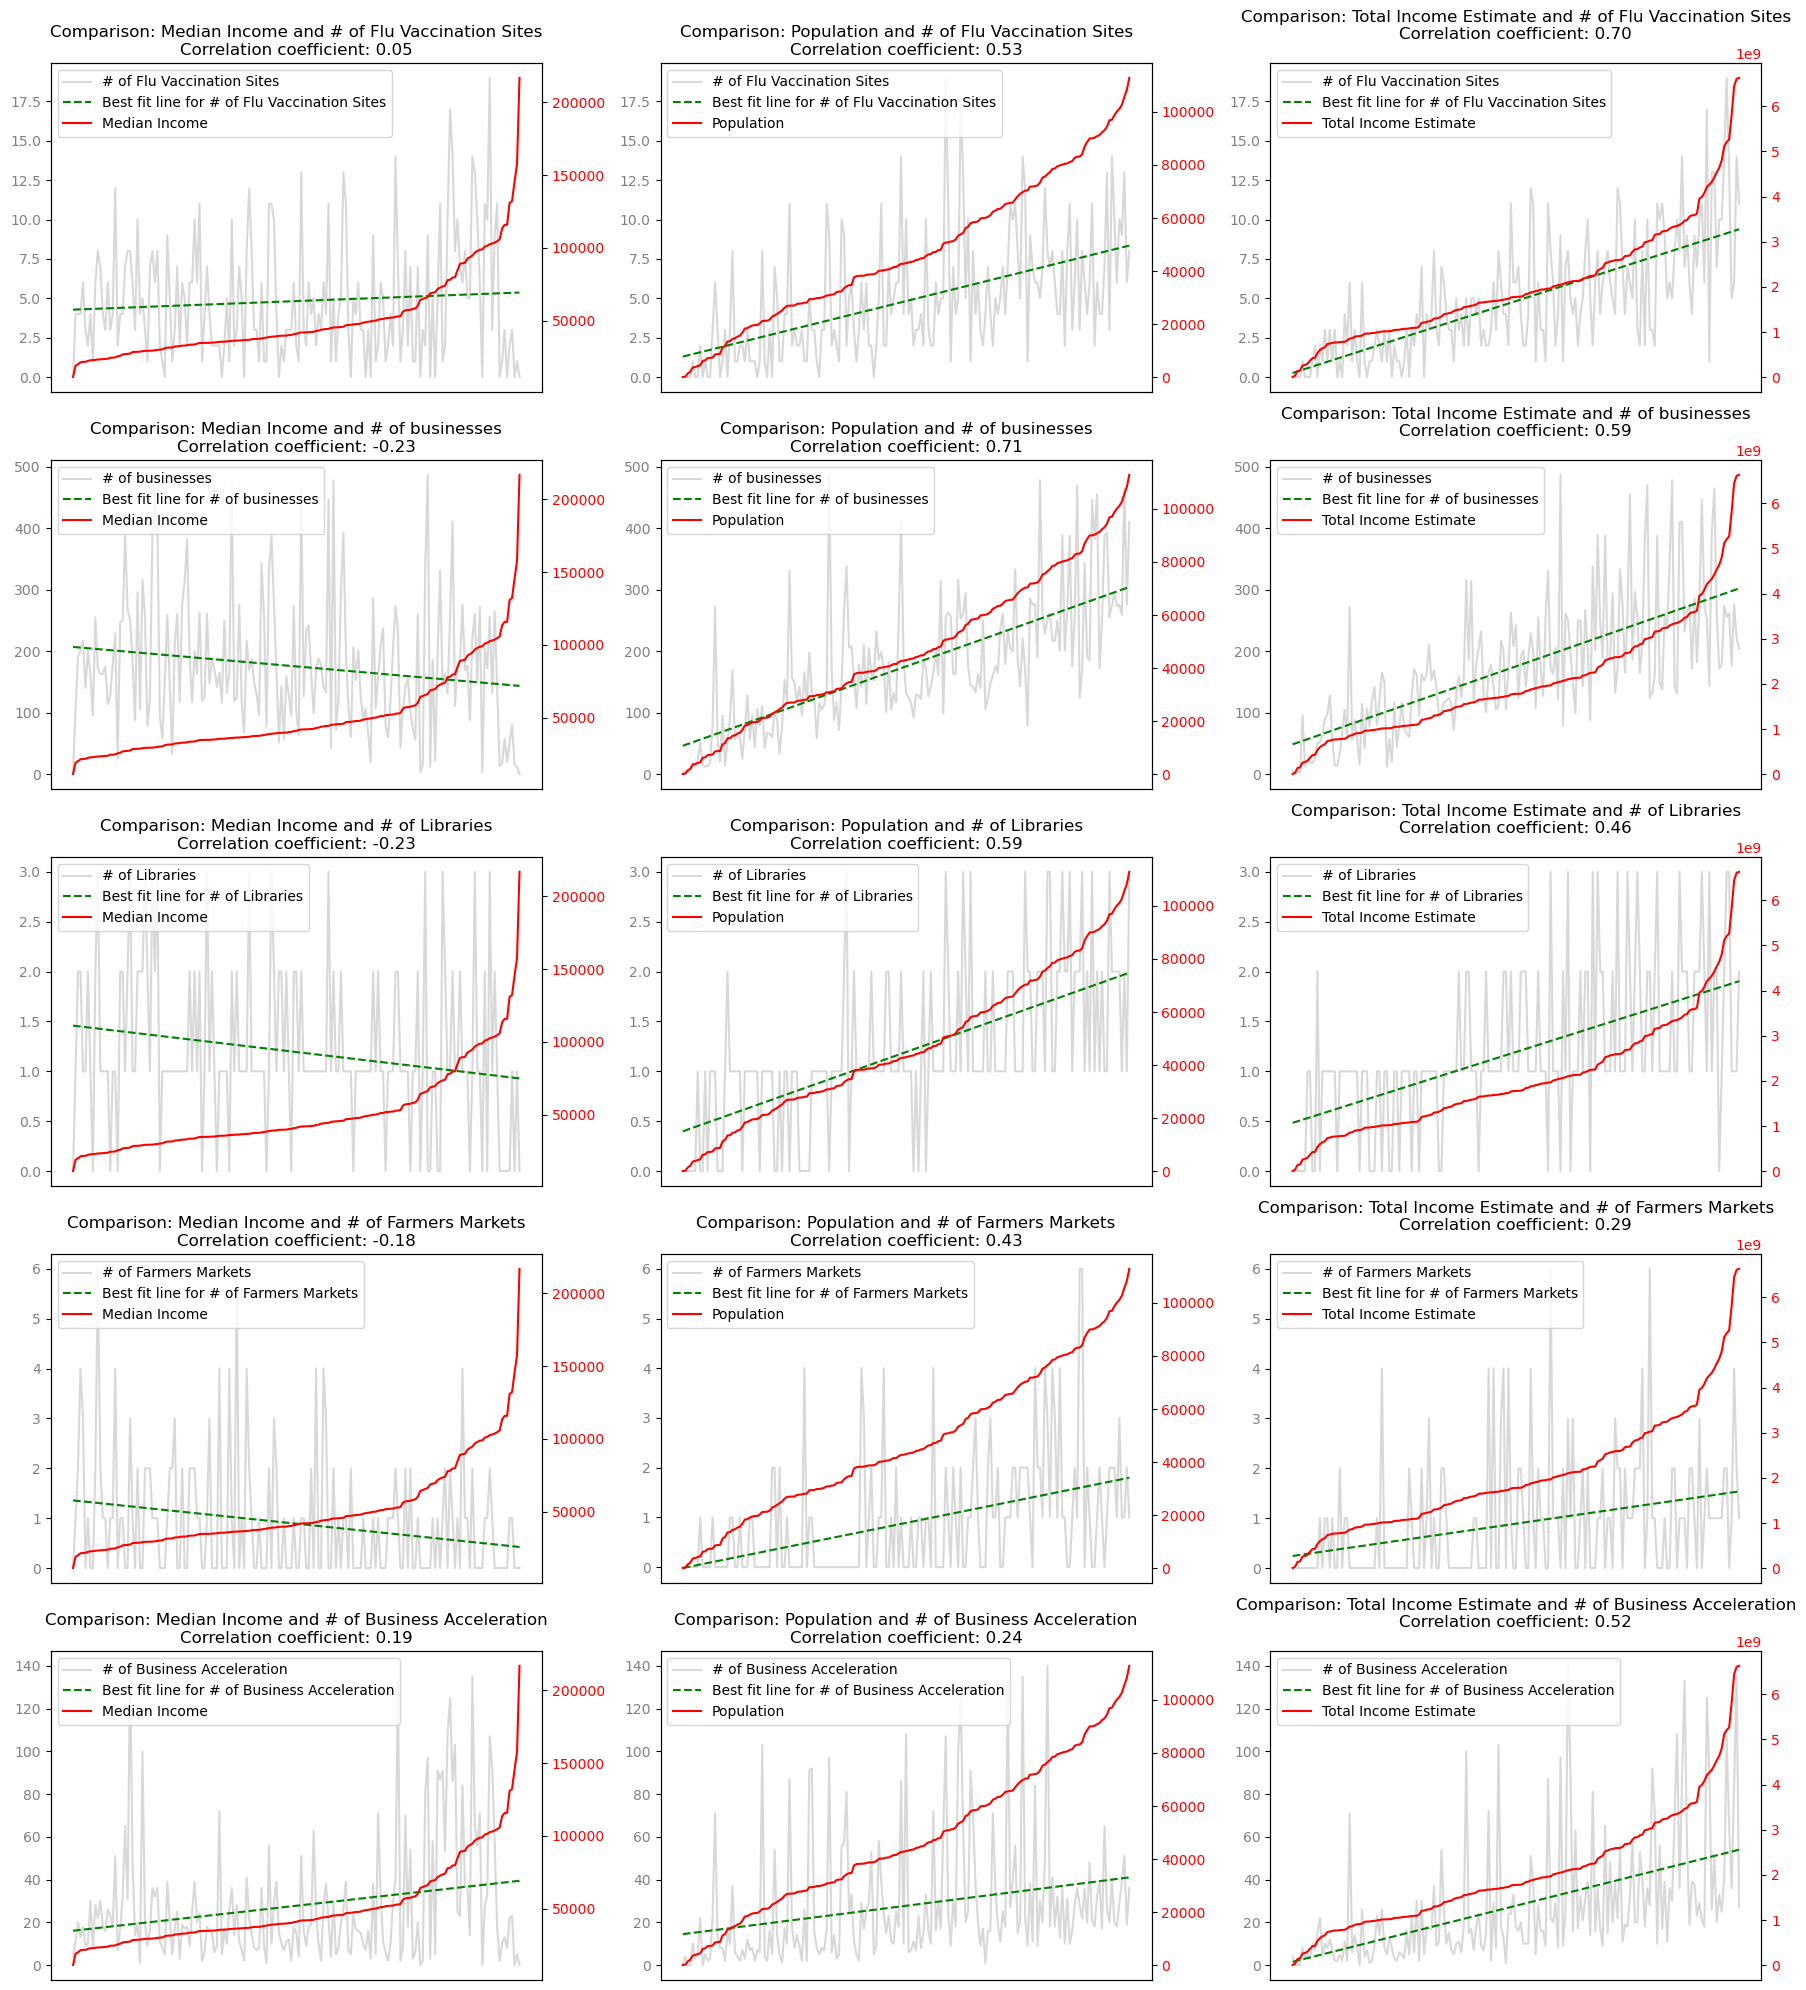

In [19]:
# plotting function:
def create_subplots(df, aux_cols, prim_cols, save_as_png=False, filename='plot.png'):
    num_aux = len(aux_cols)
    num_prim = len(prim_cols)
    
    # Generate the overall figure with a grid of subplots
    fig, axes = plt.subplots(num_aux, num_prim, figsize=(6*num_prim, 4*num_aux), squeeze=False)
    
    # Iterate through auxiliary and primary columns
    for i, aux_col in enumerate(aux_cols):
        for j, prim_col in enumerate(prim_cols):
            # As with previous graph, for each primary metric I will sort the dataframe and then plot the index along the x-axis, that way the primary
            # metric will increase from left to right on all plots
            df_sorted = df.sort_values(by=prim_col).reset_index(drop=True)
            
            # Create twin axes for separate y-axis scales
            ax1 = axes[i, j]
            ax2 = ax1.twinx()
            
            # Plot the auxiliary column on the left y-axis
            ax1.plot(df_sorted.index, df_sorted[aux_col], color='gray', linestyle='-', label=aux_col, alpha=0.3)
            ax1.tick_params(axis='y', labelcolor='gray')
            
            # Plot the primary column on the right y-axis
            ax2.plot(df_sorted.index, df_sorted[prim_col], 'r-', label=prim_col)
            ax2.tick_params(axis='y', labelcolor='r')
            
             # Calculate and plot line of best fit for auxiliary column
            x = np.arange(len(df_sorted))
            z = np.polyfit(x, df_sorted[aux_col], 1)
            p = np.poly1d(z)
            ax1.plot(x, p(x), 'g--', label=f'Best fit line for {aux_col}')

            # Calculate correlation coefficient
            corr_coef, _ = pearsonr(df_sorted[prim_col], df_sorted[aux_col])
            # Generate title and display correlation coefficient
            plt.title(f'Comparison: {prim_col} and {aux_col}\nCorrelation coefficient: {corr_coef:.2f}')

            # Remove x-axis ticks and labels
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            ax1.set_xlabel('')
            
            # Add legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    
    # Save the plot as a PNG file if requested
    if save_as_png:
        plt.savefig(filename)
        
    plt.show()

# Call function to generate plot. This plot can be exported as a png if desired
create_subplots(df, aux_cols, prim_cols, save_as_png=False, filename='correlation_plot.png')

# Generate and Export Individual Static Plots:

The two plots which I observed to have the highest correlation were the number of businesses and population, and the number of flu vaccination sites availible and total income. I would like to plot both of these relations as static plots and export them

In [21]:
# Create function to generate and export an individual plot

def create_plot(df, aux_col, prim_col, save_as_png=False, filename='plot.png'):

    # Sort and reset index of df
    df_sorted = df.sort_values(by=prim_col).reset_index(drop=True)

    #Set the size of the plot:
    fig, ax1 = plt.subplots(figsize=[10, 6])

    # Create secondary y-axis and plot auxiliary column
    ax1.plot(df_sorted[aux_col], color='gray', alpha=0.4, label=aux_col)
    ax1.set_ylabel(aux_col, color='gray')
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis='y', labelcolor='gray')

    # Plot primary column
    ax2 = ax1.twinx()
    ax2.plot(df_sorted[prim_col], color='red',label=prim_col)
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel(prim_col, color='red')
    ax2.tick_params(axis='y', labelcolor='red')



    # Calculate and plot line of best fit for auxiliary column
    x = np.arange(len(df_sorted))
    z = np.polyfit(x, df_sorted[aux_col], 1)
    p = np.poly1d(z)
    ax1.plot(x, p(x), 'g--', label=f'Best fit line for {aux_col}')

    # Calculate correlation coefficient
    corr_coef, _ = pearsonr(df_sorted[prim_col], df_sorted[aux_col])

    # Generate title and display correlation coefficient
    plt.title(f'Comparison: {prim_col} and {aux_col}\nCorrelation coefficient: {corr_coef:.2f}')

    # remove x ticks as the index has no value to visualize 
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_xlabel('')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # Save the plot as a PNG file if requested
    if save_as_png:
        plt.savefig(filename)

    plt.show()

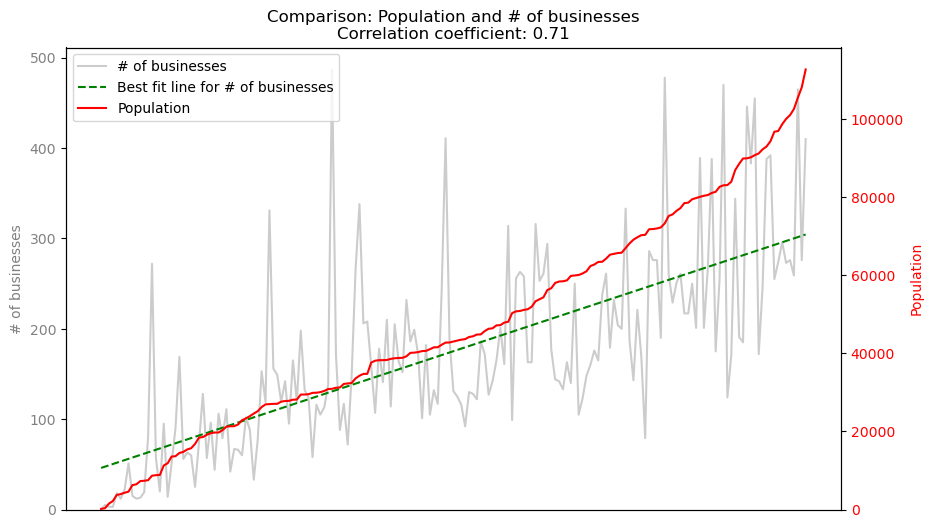

In [22]:
# Call function to generate plot. This plot can be exported as a png if desired
create_plot(df, '# of businesses', 'Population', save_as_png=False, filename='Population_plot.png')

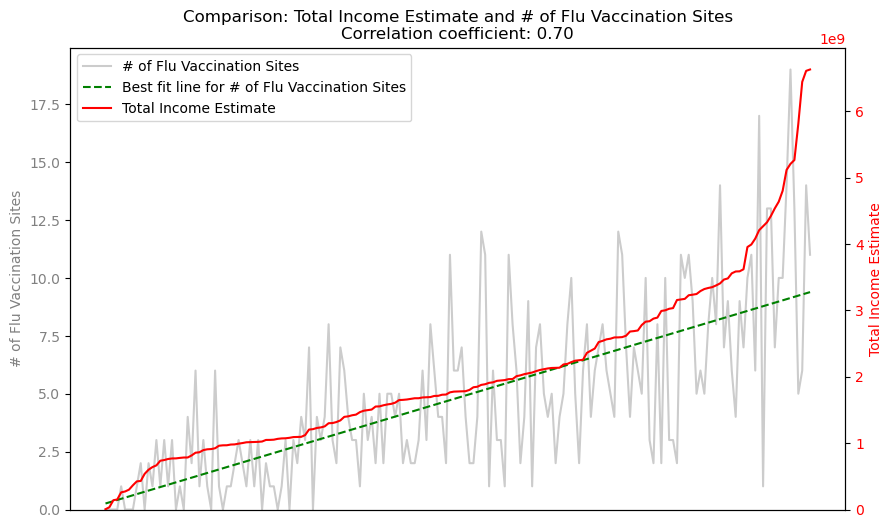

In [23]:
create_plot(df, '# of Flu Vaccination Sites', 'Total Income Estimate', save_as_png=False, filename='Total_Income.png')

# Export data to Tableau

I would like to plot visualize some of this data on maps. I will do so in tableau so I will need to export the data for this

In [43]:
df.to_csv('final_zip_code_data.csv', index=False)